
# Missing Data: Detection & Imputation — Hands‑On Notebook

This notebook contains guided **exercises** (with hints) to practice:
1. Detecting missing data
2. Interpolating **numerical** data (with outlier detection/removal first)
3. Interpolating **categorical** data (with categorical "outlier" cleaning)

> Tip: Work through the *Exercises* first. If you get stuck, peek at the **Answer Key** cells near the end.


## Setup

In [ ]:

# Minimal dependencies: pandas, numpy, scikit-learn, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


rng = np.random.default_rng(42)
pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 120)



## 1) Detecting Missing Data (Tabular, Mixed Types)

**Objective:** Find, profile, visualize, and summarize missingness patterns.


In [88]:

# --- Dataset setup (toy, mixed types) ---
rng = np.random.default_rng(7)
n = 300
df = pd.DataFrame({
    "age": rng.normal(40, 12, n).round(1),
    "income": np.exp(rng.normal(10, .6, n)).round(0),
    "city": rng.choice(["Paris","Lyon","Lille","Nice","Bordeaux"], n, p=[.35,.25,.2,.1,.1]),
    "churn": rng.integers(0,2,n)
})

# Inject MCAR/MAR/MNAR-ish missingness
df.loc[rng.choice(n, 30, replace=False), "age"] = np.nan            # MCAR-like
df.loc[df["income"]>60000, "income"] = np.nan                       # MNAR-ish (depends on value)
mask = (df["city"].eq("Paris")) & (rng.random(n) < 0.25)            # MAR-ish (depends on city)
df.loc[mask, "city"] = np.nan

df.head()


,age,income,city,churn
0,40.0,54562.0,Nice,1
1,43.6,30743.0,Lyon,1
2,36.7,21267.0,Paris,0
3,29.3,15559.0,Lille,0
4,34.5,15048.0,NaN,1



### Exercises

In this section, we’ll **detect and profile missing data** in a mixed-type DataFrame `df`.  
We’ll use key pandas tools such as:
- `isna()` — to detect missing (NaN) values  
- `assign()` — to add calculated columns to a DataFrame in a tidy way  
- `groupby()` — to summarize data by categories or flags  

Work through the tasks below in order.

---

#### 1 Column-level missingness summary
Identify which columns contain missing data and the missing data frequency using `df.isna(), df.sum()` and `df.mean()`


In [ ]:
# --- Your work here ---

# 1) Column missingness summary
col_missing = (
   # ... 
)
display(col_missing)




#### 2 Row-level missingness

Find the most incomplete records. Use `f.isna().sum(axis=1)` to count missing values across each row (axis=1 means “across columns”). You can add this as a new column using `assign()`which will creates a copy of df with an additional column without mutating the original DataFrame.

In [ ]:

# 2) Row-wise missingness

top_incomplete_rows = #...
display(top_incomplete_rows)



#### 3 Co-missingness matrix

See if missingness in one column tends to co-occur with missingness in another. One quick way to do it is to convert `df.isna()` to integers and multiply the boolean matrix by its transpose. You then still have to divide by the number of rows to get rates.

In [ ]:
# 3) Co-missingness matrix (how often two columns are missing together)

comiss_counts = #...
display(comiss_counts)
display(comiss_rates.style.format("{:.2%}"))



#### 4 Diagnostics of missingness mechanisms

Explore whether missingness might depend on other variables.

Example: Check if age being missing relates to differences in income.

Steps:

- Create a boolean flag and add this flag as a new column
- Use `df.groupby()` to compute summary statistics by this flag. `df.groupby()` splits the data by each unique value of age_missing and applies an aggregation function such as `mean(), median()`... You can use `describe()` to aggregate to have detailed statistics.



In [ ]:
# 4) Simple diagnostics (example: income by missing vs. not-missing age)
# Create a flag for whether 'age' is missing
age_missing_flag = # ...

# Summary table of income stats by age-missing vs not
# Use df.assign() to add the flag as a column and groupby + describe to compute stats on 'income'
diagnostics = (
    # ...
)
display(diagnostics)



# Visualize income distribution by age-missing vs not

import matplotlib.pyplot as plt

age_missing_flag = df['age'].isna()
plt.figure()
df.loc[~age_missing_flag, 'income'].plot(kind='hist', bins=30, alpha=0.7, label='age present')
df.loc[age_missing_flag, 'income'].plot(kind='hist', bins=30, alpha=0.7, label='age missing')
plt.title("Income distribution by Age Missingness")
plt.xlabel("income")
plt.ylabel("count")
plt.legend()
plt.show()


## 2) Numerical Interpolation (Time Series)

We will detect gaps and **outliers**, remove outliers by setting them to `NaN`, then compare interpolation methods.

**Signal**: smooth trend + daily seasonality + noise, with injected gaps & spikes.


In [12]:

# --- Dataset setup (time series with gaps and spikes) ---
idx = pd.date_range("2025-01-01", periods=500, freq="h")
t = np.arange(len(idx))
signal = 10 + 0.02*t + 2*np.sin(2*np.pi*t/24) + np.random.normal(0, .8, len(t))
ts = pd.DataFrame({"y": signal}, index=idx)

# Inject missing stretches
ts.loc["2025-02-05 03":"2025-02-05 18", "y"] = np.nan
ts.loc["2025-03-12 10":"2025-03-12 22", "y"] = np.nan

# Inject random missing points
miss_idx = np.random.choice(len(ts), 40, replace=False)
ts.iloc[miss_idx] = np.nan

# Inject outliers (spikes)
spike_idx = np.random.default_rng(1).choice(len(ts), 8, replace=False)
ts.loc[ts.index[spike_idx], "y"] += np.random.choice([10,-12,15,-15], size=8)

ts.head(10)


,y
2025-01-01 00:00:00,9.867286
2025-01-01 01:00:00,11.510906
2025-01-01 02:00:00,9.910256
2025-01-01 03:00:00,12.914478
2025-01-01 04:00:00,12.131988
2025-01-01 05:00:00,12.888202
2025-01-01 06:00:00,11.908856
2025-01-01 07:00:00,12.628010
2025-01-01 08:00:00,11.929871
2025-01-01 09:00:00,11.691061



### Detecting Missing Data and Outliers

In this step, we’ll identify **outliers** in our time series — sudden spikes or drops that don’t fit the local pattern — before we move on to interpolation.
Outliers can distort interpolation and trend estimation.  

We want to:
1. Detect abnormal points based on their **distance from the local trend**, and  
2. Replace or mark them as missing (`NaN`) so that they can be **interpolated smoothly** later.

To do this robustly, we’ll use:
- a **rolling median** as a local baseline, and  
- the **Median Absolute Deviation (MAD)** as a robust local measure of variability.

`df.rolling()` is a pandas method that creates a **moving window** over the data.  
It allows you to compute statistics (like mean, median, or standard deviation) over *sliding windows* of time or fixed-size subsets of observations.

- If you pass a **time-based window** like `"24H"`, it means “look back over the last 24 hours” — perfect for time-indexed data.  
- If you pass an **integer**, e.g. `window=24`, it means “look at the last 24 rows.”  
- You can then apply aggregations like `.mean()`, `.median()`, `.std()`, or even custom functions via `.apply()`.

Example:
```python
y.rolling("24H").mean()
```
returns a Series where each value is the mean of the previous 24 hours.


#### Exercise 

* First plot the raw data series
* Then compute the missingness ratio globally and rolling (over 24h)
* Build a robust outlier detector by computing the local median within each 24-hours window and calculate how much each point typically deviates from the local median — that’s the MAD (Median Absolute deviation): 

$$\text{mad}=\text{median}(∣x_i​−median(x)∣)$$

* Compute robust Z-scores and flag outliers. You have to standardize each point’s deviation from the median using the MAD:
$$z = \frac{x_i - \text{median}}{1.4826 \text{mad}}$$
1.4826 is a constant that scales the MAD to make it comparable to the standard deviation under a normal distributio. If $|z| > 3$, it’s likely an outlier (similar logic to “$3\sigma$ rule” in statistics).
 

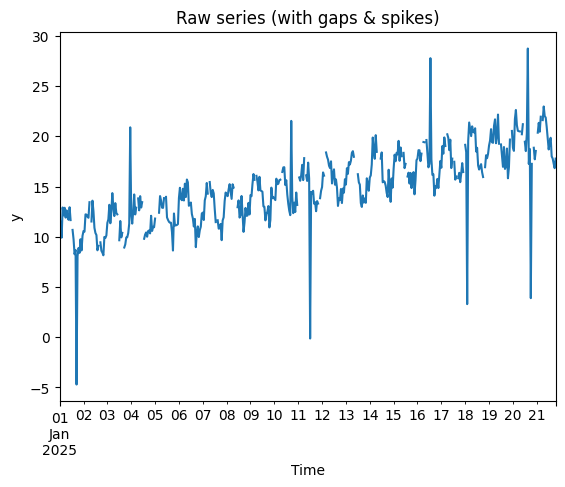

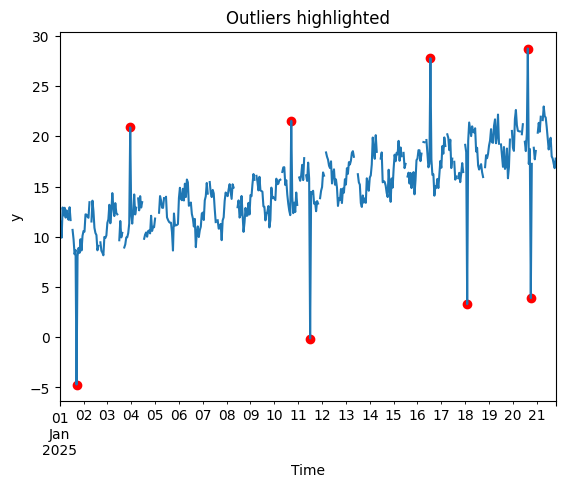

In [ ]:

# --- Your work here ---

# 1) Plot raw series

# 2) Missingness ratio overall and rolling (24h)


# 3) Robust outlier detection
y = ts["y"].sort_index().asfreq("h") # ensure monotonic and lign to hourly grid (introduces NaNs if gaps)
med = #...
mad = #...

robust_z = #...
outlier_mask = robust_z.abs() > 3

# Visual check: overlay outliers
plt.figure()
y.plot()
plt.scatter(y.index[outlier_mask], y[outlier_mask], marker="o", color="red", label="Outliers")
plt.title("Outliers highlighted")
plt.xlabel("Time")
plt.ylabel("y")
plt.show()



### Exercise Removing Outliers

1. Create `y_clean` where outliers are set to `NaN`.  
2. Compare distributions before/after (boxplot or `describe()`).  
3. Keep an outlier mask for later overlay.


In [ ]:

# --- Your work here ---
ts["y_clean"] = #...


,y,y_clean
count,460.000000,452.000000
mean,14.923432,14.963443
std,3.662792,3.280205
min,-4.709595,8.065012
25%,12.315503,12.371522
50%,14.849609,14.849609
75%,17.512816,17.438827
max,28.741925,22.972671



### Interpolation of Missing Values

Now that you have identified and removed outliers (by setting them to `NaN`), it’s time to **reconstruct** the time series.

Our goal is to **fill in missing data** points using several imputation strategies, then **compare their accuracy**.

---

#### Background: What is interpolation?

Interpolation means **estimating missing values** that fall *between known observations*.  
For time series data, interpolation often relies on temporal structure — assuming nearby points are related in time.

Common interpolation families:
- **Rule-based** (forward / backward fill)
- **Mathematical** (linear, spline, polynomial)
- **Model-based** (machine learning, regression, etc.)

---

We will create **four reconstructed versions** of the same signal, each using a different method.

---

##### Forward/Backward Fill (Baseline)
Simplest approach:
- Fill each missing point with the **last known value** (`ffill`).
- If gaps remain at the start, fill backward (`bfill`).



In [ ]:
# Candidate imputations (built on y_clean)
candidates = {}
candidates["ffill_bfill"] = ## your code here ##



#### Time-based Interpolation

Leverages the timestamps of your series.

Uses linear interpolation `df.interpolate(method="time", limit_direction="both")` along the time axis rather than the row index.

Works best when data have a consistent time frequency (e.g., hourly).

In [ ]:
candidates["time"] =  ## your code here ##

#### Spline Interpolation (Cubic, Order=3)

Uses cubic spline polynomials to fit smooth curves through known points: `df.interpolate(method="spline", order=3, limit_direction="both")`

Ideal for periodic or smoothly changing signals.

In [ ]:
candidates["spline3"] =  ## your code here ##


#### Seasonal Regression (Model-based)

Fit a regression model that predicts values based on known seasonal patterns:

Hour of day (captures daily cycles)

Day of week (captures weekday/weekend effects)

Optional: time trend (captures drift)

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression

# Seasonal regression (hour, day-of-week)
# Create a dataframe with features 
# hour of day, day of week, and time trend
df_feat = pd.DataFrame({
   ## your code here ## 
}, index=ts.index) 

# Train on non-missing rows only
# Remove rows where y_clean is NaN use notna() to create a mask
# You can use pd.get_dummies to create one hot encoding of categorical variables hour and dow

train_mask = #...
X = #... Use pd.get_dummies()
y_known = df_feat.loc[train_mask, "y_clean"]

# Fit a Ridge regression model to predict y_clean from hour, dow, t using Ridge() and fit()
ridge = Ridge(alpha=1.0)


# Predict everywhere, then fill missing
# Use pd.Series() to create a series from the predictions with the same index as df_feat
# Use ridge.predict() to get predictions
# You can use df.fillna() to fill missing values
X_all = #... Use pd.get_dummies()
pred_all = pd.Series(ridge.predict(X_all), index=df_feat.index)

y_reg = #...
candidates["ridge_seasonal"] = y_reg

#### Visualize and interpret

Finally, plot your original vs. reconstructed series

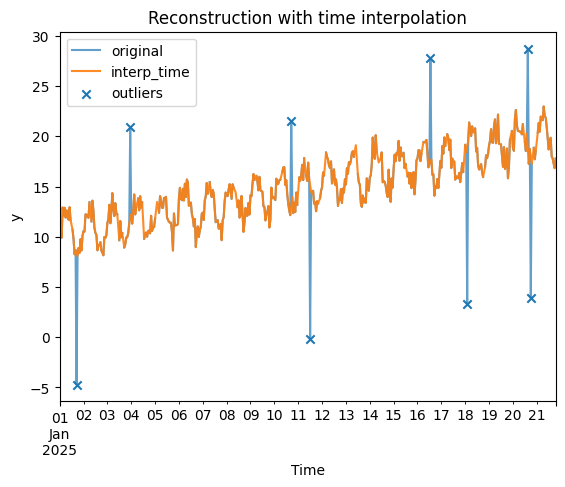

In [85]:

# Plot final reconstruction example
plt.figure()
ts["y"].plot(alpha=0.7, label="original")
candidates["time"].plot(alpha=0.9, label="interp_time")
plt.scatter(ts.index[outlier_mask], ts.loc[outlier_mask, "y"], marker="x", label="outliers")
plt.title("Reconstruction with time interpolation")
plt.xlabel("Time")
plt.ylabel("y")
plt.legend()
plt.show()



## 3) Categorical Interpolation (Tabular)

Treat categorical **outliers** as rare/erroneous levels, then impute missing categories.


In [95]:

# --- Dataset setup (customer-style table) ---
rng = np.random.default_rng(3)
n = 600
dfc = pd.DataFrame({
    "segment": rng.choice(["A","B","C"], n, p=[.5,.35,.15]),
    "region": rng.choice(["North","South","East","West"], n, p=[.3,.25,.25,.2]),
    "channel": rng.choice(["Web","Store","Phone"], n, p=[.6,.3,.1]),
    "spend": np.round(np.exp(rng.normal(3.7, .7, n))*10, 2)
})
# Missingness related to other columns
dfc.loc[dfc["segment"].eq("C") & (rng.random(n) < .35), "region"] = np.nan
dfc.loc[rng.random(n) < .10, "channel"] = np.nan
# Typos/rare categories
typo_idx = rng.choice(n, 15, replace=False)
dfc.loc[typo_idx, "region"] = rng.choice(["Nrth","Soth","Eest","Weest"], len(typo_idx))
dfc.head()


,segment,region,channel,spend
0,A,South,Web,467.11
1,A,East,Web,783.96
2,B,West,Web,274.97
3,B,South,Store,1053.24
4,A,West,Phone,232.97



### Exercise Removing Categorical Outliers (Cleaning)

1. Map typos to nearest known labels (rule-based).  
2. Collapse remaining very rare categories into `"Other"`.  
3. Produce a small before/after data quality report.


In [ ]:

# --- Your work here ---

# 1) Typo map (rule-based)
typo_map = # Construct the typo mapping dictionary
dfc_clean = dfc.copy()
dfc_clean["region"] = dfc_clean["region"].replace(typo_map)

# 2) Collapse very rare categories in channel into "Other". Use value_counts to detect rare ones

dfc_clean["channel"] = #....

# 3) Quality report (before vs after)
quality = pd.DataFrame({
    "missing_before": dfc.isna().sum(),
    "missing_after": dfc_clean.isna().sum()
})
quality


,missing_before,missing_after
segment,0,0
region,19,19
channel,67,67
spend,0,0



###  Interpolation (Imputation) of Missing Categorical Values

In this section, we’ll learn how to **fill in missing categorical data** using three complementary approaches, and then **compare their effectiveness** on a realistic validation setup.

---

We focus on imputing the column **`region`**, which has missing values introduced earlier.

To measure accuracy objectively, we’ll create a **masked validation fold**:
- Hide (set to `NaN`) **15% of the rows** where `region` is *known*.
- Use the remaining rows to train or compute the imputation rules.
- Evaluate how well each method reconstructs the hidden (true) categories.

This gives us a fair comparison between simple statistical imputations and model-based ones.

#### Global Mode Imputation (Most Frequent Category)

Fill all missing `region` values with the single most frequent category in the column (the *global mode*).

```python
mode_val = df["region"].mode().iloc[0]
df["region_filled"] = df["region"].fillna(mode_val)
```

#### Conditional Mode by Groups (segment, channel)

Use contextual information — if region is missing, look at rows with the same combination of segment and channel, and use the most frequent region within that subgroup.

#### Model-based Imputation (Logistic Regression)

Train a classification model to predict region based on other features:

* Categorical predictors: segment, channel
* Numeric predictor: spend

Then use this model to predict missing region values.

In [100]:
from sklearn.metrics import accuracy_score, f1_score

# Helper: conditional mode by groups
def fill_by_group_mode(df, col, by, global_default):
    filled = df[col].copy()
    for keys, sub in df.groupby(by):
        mode = sub[col].mode()
        local = mode.iloc[0] if not mode.empty else global_default
        idx = sub.index[sub[col].isna()]
        filled.loc[idx] = local
    return filled


# Helper: evaluate accuracy and macro F1
def eval_pair(y_true_s, y_pred_s):
    # Keep only rows where both sides are present
    m = y_true_s.notna() & y_pred_s.notna()
    yt = y_true_s[m].astype(str).to_numpy()
    yp = y_pred_s[m].astype(str).to_numpy()
    return accuracy_score(yt, yp), f1_score(yt, yp, average="macro")


df_work = dfc_clean.copy()


# Build a validation mask (hide 15% of known region values)
known_idx = df_work.index[df_work["region"].notna()]
val_idx = rng.choice(known_idx, size=int(0.15 * len(known_idx)), replace=False)
y_true = df_work.loc[val_idx, "region"].copy()

# Create masked target for evaluation
masked = df_work.copy()
masked.loc[val_idx, "region"] = np.nan

# 1) Global mode
mode_val = masked["region"].mode().iloc[0]
pred_mode = masked["region"].fillna(mode_val)

# 2) Conditional mode by (segment, channel)
global_default = mode_val
pred_group = fill_by_group_mode(masked, "region", ["segment","channel"], global_default)

# 3) Model-based imputation (LogReg)
train_rows = masked["region"].notna()
X_train = masked.loc[train_rows, ["segment","channel","spend"]]
y_train = masked.loc[train_rows, "region"]
X_val = masked.loc[val_idx, ["segment","channel","spend"]]

ct = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["segment","channel"]),
    ("num", "passthrough", ["spend"])
])
clf = Pipeline([("prep", ct), ("clf", LogisticRegression(max_iter=1000))]).fit(X_train, y_train)
pred_ml = pd.Series(clf.predict(X_val), index=val_idx)

# Collect predictions for evaluation rows only
pred_mode_eval = pred_mode.loc[val_idx]
pred_group_eval = pred_group.loc[val_idx]
pred_ml_eval    = pred_ml.loc[val_idx]  # already indexed to val_idx

acc = {}
f1  = {}

acc["mode"],       f1["mode"]       = eval_pair(y_true, pred_mode_eval)
acc["group_mode"], f1["group_mode"] = eval_pair(y_true, pred_group_eval)
acc["logreg"],     f1["logreg"]     = eval_pair(y_true, pred_ml_eval)

pd.DataFrame({"accuracy": acc, "macro_f1": f1})


/home/rambour/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,macro_f1
mode,0.183908,0.077670
group_mode,0.285714,0.183847
logreg,0.252874,0.192127


Here, we generated the toy data so that region is (basically) independent of segment, channel, and spend, so any method that tries to predict region from those features will be close to random guessing.